# Прогнозирование заказов такси

Исследование для компании такси. Нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Данные для модели - исторические данные о заказах такси в аэропортах. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
# загружаю все нужные для проекта библиотеки

!pip install catboost

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import lightgbm as lgb
import os

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
def load_data(file_name): # загрузка данных
    data = pd.read_csv(file_name, parse_dates=[0], index_col=0)
    print(data.head())
    data.info()
    return data

In [3]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [4]:
def data_for_model(data, drop_col, num_columns): # подготовка данных для моделей
    X = data.drop(drop_col, axis=1)
    y = data[drop_col[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state = RANDOM_STATE, test_size=TEST_SIZE)
    
    standard = StandardScaler()
    X_train_scaled = standard.fit_transform(X_train[num_columns])
    X_test_scaled = standard.transform(X_test[num_columns])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)


    return X_train_scaled, X_test_scaled, y_train, y_test

## Загрузка и ресемплирование данных

In [5]:
pth1 = '/Users/ira-bobrineva/Downloads/taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = load_data(pth1)
elif os.path.exists(pth2):
    data = load_data(pth2)
else:
    print('Something is wrong')

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Изучение данных

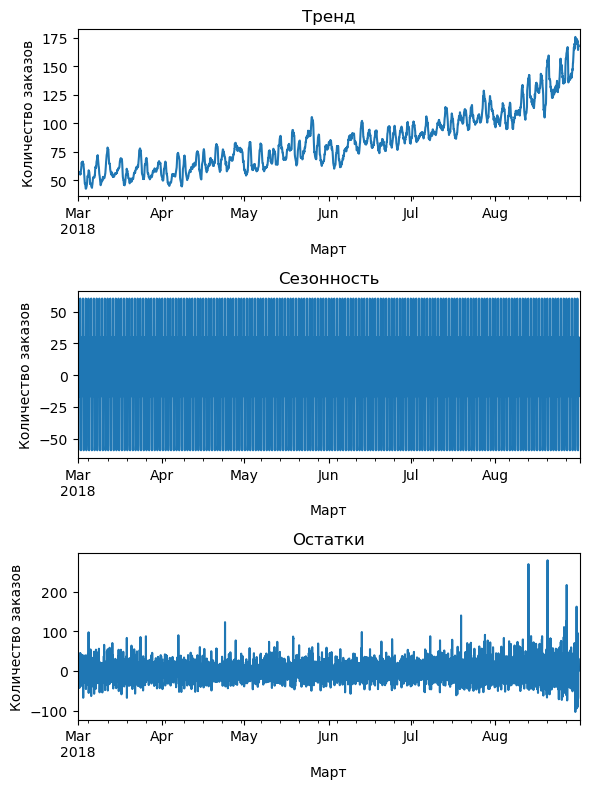

In [7]:
# посмотрим на тренды и сезонность 
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Март')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Март')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Март')
plt.ylabel('Количество заказов')
plt.tight_layout()

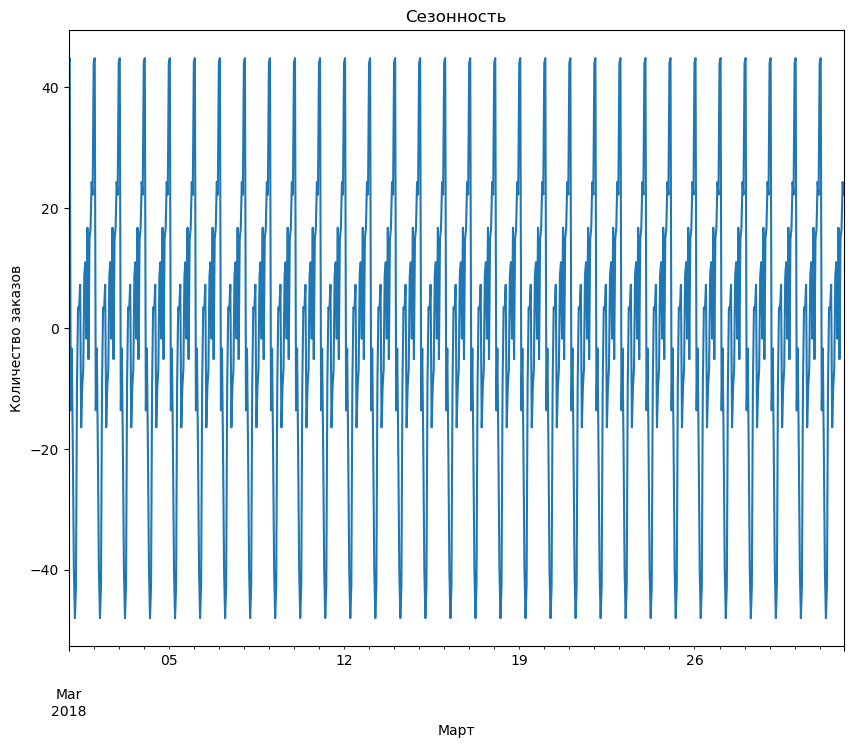

In [8]:
# сезонность видно не очень хорошо, попробую уменьшить период до нескольких недель
data_weeks = data['2018-03-01':'2018-03-31']
decomposed_weeks = seasonal_decompose(data_weeks) 
plt.figure(figsize=(10, 8))
decomposed_weeks.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Март')
plt.ylabel('Количество заказов')
plt.show()

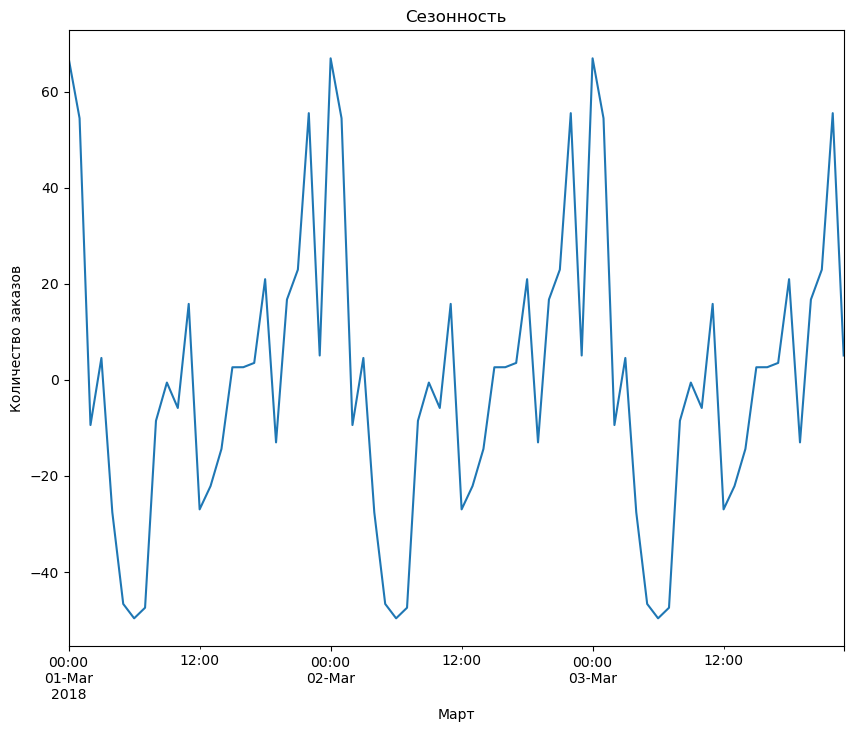

In [9]:
# уменьшу период ещё больше, чтобы лучше рассмотреть сезонность
# период - несколько дней
data_3days = data['2018-03-01':'2018-03-03']
decomposed_days = seasonal_decompose(data_3days) 
plt.figure(figsize=(10, 8))
decomposed_days.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Март')
plt.ylabel('Количество заказов')
plt.show()

Можно отметить полугодовой тренд: количество заказов растёт к августу. Возможно, аэропорт, куда заказывают такси, находится в какой-то жаркой стране, в которой туристический сезон начинается к осени. Сезонность данных - посуточная. Количество заказов сильно растёт с 12:00 до 0:00, затем резкий спад с 0:00 до 6:00, а потом снова рост до 12 со спадами. Думаю, такая сезонность связана с особенностями прилётов самолётов: прилетают чаще воздно вечером или днём. Ночью прилётов не так много, поэтому и такси в аэропорт заказывать не нужно. А вот вылетов ночью обычно много, но тогда такси заказывают не в аэропорт, а до аэропорта.

<function matplotlib.pyplot.show(close=None, block=None)>

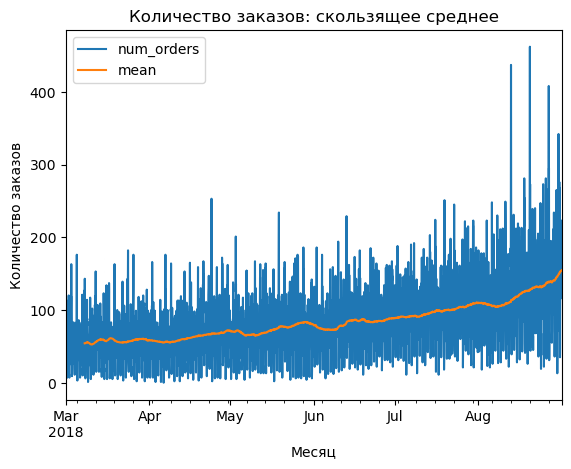

In [10]:
data['mean'] = data['num_orders'].shift().rolling(168).mean()
data[['num_orders', 'mean']].plot()
plt.title('Количество заказов: скользящее среднее')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Ряд нестационарный, поэтому его надо сделать стационарным: вычислим разности временного ряда, после изучения сезонности и трендов.

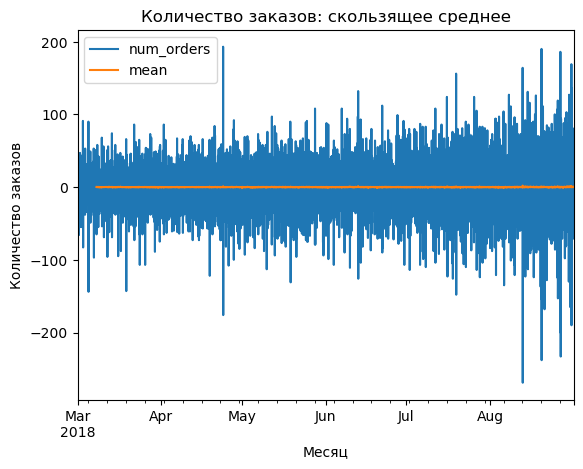

In [11]:
# вычисляю разности временного ряда и делаю ряд стационарным
data = data - data.shift()
data['mean'] = data['num_orders'].shift().rolling(168).mean()
data[['num_orders', 'mean']].plot()
plt.title('Количество заказов: скользящее среднее')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

## Добавление признаков

In [12]:
make_features(data, 10, 168)

,num_orders,mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,1,3,2,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,1,3,3,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,1,3,4,-5.0,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,0.136905,31,4,19,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,21.0,0.416667
2018-08-31 20:00:00,18.0,-0.148810,31,4,20,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,0.136905
2018-08-31 21:00:00,5.0,-0.041667,31,4,21,18.0,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-0.148810


In [13]:
print(data.head())
print(data.info())

                     num_orders  mean  day  dayofweek  hour  lag_1  lag_2  \
datetime                                                                    
2018-03-01 00:00:00         NaN   NaN    1          3     0    NaN    NaN   
2018-03-01 01:00:00       -39.0   NaN    1          3     1    NaN    NaN   
2018-03-01 02:00:00       -14.0   NaN    1          3     2  -39.0    NaN   
2018-03-01 03:00:00        -5.0   NaN    1          3     3  -14.0  -39.0   
2018-03-01 04:00:00       -23.0   NaN    1          3     4   -5.0  -14.0   

                     lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
datetime                                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN    NaN    NaN    Na

In [14]:
# после добавления новых признаков, появились нулевые значения в датасете
# уберу эти нулевые значения
data = data.dropna()
data.head()

,num_orders,mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-08 01:00:00,-65.0,-0.041667,8,3,1,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-5.0,8.0,0.113095
2018-03-08 02:00:00,-13.0,-0.035714,8,3,2,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-5.0,-0.041667
2018-03-08 03:00:00,3.0,0.011905,8,3,3,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-0.035714
2018-03-08 04:00:00,-8.0,0.101190,8,3,4,3.0,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,0.011905
2018-03-08 05:00:00,-54.0,0.000000,8,3,5,-8.0,3.0,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,0.101190


In [15]:
phik_matrix = data.phik_matrix(interval_cols = ['mean', 'rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])

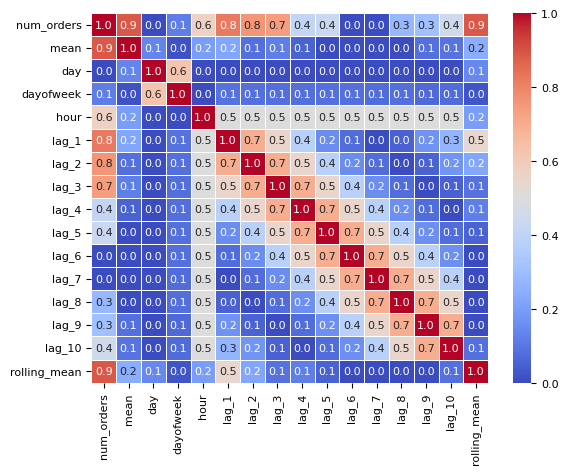

In [16]:
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

Признаки мультиколлениарны. Значит, для предсказания значений на следующий час нужно использовать модели, которые устойчивы к мультиколлениарности - древесные и бустинговые.

## Пайплайн для моделей

In [17]:
data.duplicated().sum()

0

In [18]:
data

,num_orders,mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-08 01:00:00,-65.0,-0.041667,8,3,1,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-5.0,8.0,0.113095
2018-03-08 02:00:00,-13.0,-0.035714,8,3,2,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-5.0,-0.041667
2018-03-08 03:00:00,3.0,0.011905,8,3,3,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,2.0,-0.035714
2018-03-08 04:00:00,-8.0,0.101190,8,3,4,3.0,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,51.0,0.011905
2018-03-08 05:00:00,-54.0,0.000000,8,3,5,-8.0,3.0,-13.0,-65.0,49.0,-33.0,19.0,32.0,26.0,-49.0,0.101190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,0.136905,31,4,19,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,21.0,0.416667
2018-08-31 20:00:00,18.0,-0.148810,31,4,20,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,0.136905
2018-08-31 21:00:00,5.0,-0.041667,31,4,21,18.0,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-0.148810


Потребуются следующие преобразования значений перед обучением:

Кодировка 'lag_1' - 'lag_10', 'rolling_mean', 'mean' с помощью StandardScaler. Для проверки качества модели - метрика RMSE. Метрика должна быть меньше 48.

In [19]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
tss = TimeSeriesSplit(n_splits=5)


X = data.drop(['num_orders'], axis=1)
y = data['num_orders']


num_columns = ['mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'rolling_mean']

In [20]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [21]:
param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },

    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(1, 100),
        'models__max_depth': range(1, 20),
        'models__min_child_samples': range(1, 20),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(1, 100),
        'models__max_depth': range(1, 20),
        'models__min_child_samples': range(1, 20),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=tss,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [22]:
randomized_search.fit(X, y)

best_model = randomized_search.best_estimator_

best_model

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2218
[LightGBM] [Info] Number of data points in the train set: 4247, number of used features: 12
[LightGBM] [Info] Start training from score 0.014599


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['mean', 'lag_1', 'lag_2',
                                                   'lag_3', 'lag_4', 'lag_5',
                                                   'lag_6', 'lag_7', 'lag_8',
                                                   'lag_9', 'lag_10',
                                                   'rolling_mean'])])),
                ('models',
                 LGBMRegressor(max_depth=10, min_child_samples=8,
                               n_estimators=81, random_state=42))])

In [23]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')
result['mean_test_score'] = result['mean_test_score'] * (-1)
print(result)
pd.set_option('display.max_colwidth', 10000)

   rank_test_score                                       param_models  \
4                1                     LGBMRegressor(random_state=42)   
9                2                     LGBMRegressor(random_state=42)   
2                3                     LGBMRegressor(random_state=42)   
7                4                     LGBMRegressor(random_state=42)   
0                5                     LGBMRegressor(random_state=42)   
5                6                     LGBMRegressor(random_state=42)   
6                7  <catboost.core.CatBoostRegressor object at 0x1...   
1                8                     LGBMRegressor(random_state=42)   
3                9                     LGBMRegressor(random_state=42)   
8               10                     LGBMRegressor(random_state=42)   

   mean_test_score                                             params  
4        30.814933  {'preprocessor__num': 'passthrough', 'models__...  
9        30.817081  {'preprocessor__num': 'passthrou

Лучшая модель для предсказаний LGBMRegressor со следующими гиперпараметрами: n_estimators = 81,  min_child_samples = 8, max_depth = 10.

## Предсказания

In [24]:
drop_col = ['num_orders']

X_train, X_test, y_train, y_test = data_for_model(data, drop_col, num_columns)

X_train.head()

,mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
0,-0.388368,1.409360,-0.949035,0.546227,0.919909,0.747695,-1.409211,1.466702,0.057377,-0.144349,0.229439,0.673979
1,-0.347524,-1.870032,1.409531,-0.949660,0.545979,0.920317,0.748457,-1.409682,1.466838,0.057052,-0.144610,-0.388228
2,-0.020776,-0.374169,-1.869451,1.409239,-0.949740,0.546304,0.921071,0.747606,-1.409614,1.466857,0.056801,-0.347374
3,0.591876,0.086097,-0.373775,-1.870207,1.408894,-0.949748,0.547075,0.920189,0.747725,-1.410296,1.466678,-0.020541
4,-0.102463,-0.230336,0.086433,-0.374319,-1.870183,1.409411,-0.948908,0.546259,0.920312,0.747568,-1.410622,0.592270


In [25]:
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 3397, number of used features: 12
[LightGBM] [Info] Start training from score 0.000294
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


41.37700370243461

## Выводы

Лучше всего для предсказания временного ряда сейчас подходит регрессионная бустинговая модель. На тестовой выборке значение метрики - 41. 